# Li-ion Battery Aging Datasets (NASA): as an RUL problem

In this notebook, we define an RUL problem out of the dataset, using only the charge and discharge cycle data, and ignoring the impedance measurement data.
We focus on data from the four batteries in the `1. BatteryAgingARC-FY08Q4` folder; the experimental conditions on the four batteries are the same within this folder. The (minimally) processed labeled dataset exported from this notebook will be used in the subsequent notebooks for baseline ML model training and evaluation.

1. Load data and re-combine charge and discharge cycle data
2. Construct cumulative time (`time`) over the whole experiment
3. Construct piecewise-linear RUL target label from `time`
4. Drop the `Capacity` column (which is not present in charge cycles)


Reference:
B. Saha and K. Goebel (2007). "Battery Data Set", NASA Prognostics Data Repository, NASA Ames Research Center, Moffett Field, CA

```
Author: Cedric Yu
Last modified: 20230105
```

In [1]:
# Load the "autoreload" extension so that code can change
import os
import pandas as pd
import numpy as np
from utils.utils import add_RUL

%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2


## Load processed battery data

In [17]:
datafolder = '../../li_ion_battery_aging_nasa/data/processed/1. BatteryAgingARC-FY08Q4'
battery_names = ['B0005', 'B0006', 'B0007', 'B0018']
initial_RUL = 1000000.
# battery_names = ['B0005']


In [18]:
for battery in battery_names:
    charge_filepath = os.path.join(datafolder, f'{battery}_charge.csv')
    discharge_filepath = os.path.join(datafolder, f'{battery}_discharge.csv')
    # impedance_filepath = os.path.join(datafolder, f'{battery}_impedence.csv')

    df_charge_cycles = pd.read_csv(charge_filepath)
    df_discharge_cycles = pd.read_csv(discharge_filepath)
    # df_impedance_cycles = pd.read_csv(impedance_filepath)

    # Re-combine charge and discharge cycle data
    df_charge_cycles['type'] = 'charge'
    df_charge_cycles['Capacity'] = np.nan

    df_discharge_cycles['type'] = 'discharge'
    # Rename `Current_load` and `Voltage_load` into `Current_charge` and
    # `Voltage_charge`. See readme in raw data folder
    df_discharge_cycles = df_discharge_cycles.rename(
        columns={'Current_load': 'Current_charge',
                 'Voltage_load': 'Voltage_charge'})

    df = pd.concat([df_charge_cycles, df_discharge_cycles])
    df = df.sort_values(['cycle_time_start', 'cycle_num', 'Time'],
                        ascending=True)

    # construct time column
    df_cum_time = df[['cycle_time_start', 'Time']]\
        .groupby(['cycle_time_start']).last().reset_index()
    df_cum_time['Time'] = df_cum_time['Time'].shift(fill_value=0)
    df_cum_time['Time'] = df_cum_time['Time'].cumsum()
    df_cum_time = df_cum_time.rename(columns={'Time': 'cum_time'})
    df_ = pd.merge(df, df_cum_time,
                   on='cycle_time_start', how='inner').drop_duplicates()
    df_['time'] = df_['Time'] + df_['cum_time']
    # drop 'Capacity' and other columns
    df_ = df_.drop(['Capacity', 'cycle_num', 'cycle_time_start',
                    'Time', 'cum_time', 'ambient_temperature'], axis=1)

    df_ = add_RUL(df_, piecewise=True, initial_RUL=1000000.)
    df_.to_csv(f'./{battery}_RUL.csv', index=False)


<AxesSubplot: >

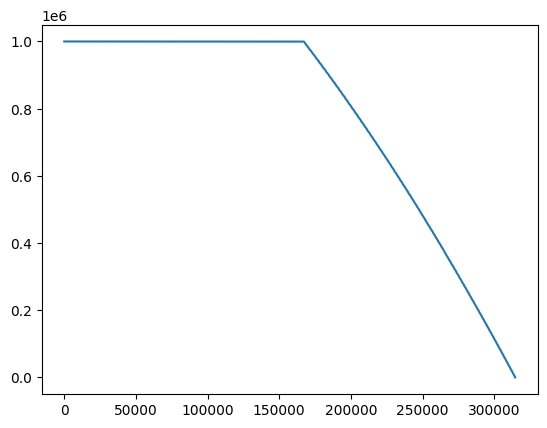

In [19]:
df_['RUL'].plot()
